In [38]:
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
from keras import datasets, layers, models # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd
import os
import cv2 as cv
from keras.applications.vgg19 import VGG19

In [26]:
# Establish filepaths 
all_0 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_0/all"
all_1 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_1/all"
all_2 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_2/all"

hem_0 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_0/hem"
hem_1 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_1/hem"
hem_2 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_2/hem"
print(all_0)

/Users/isaacbilsel/Documents/GW_Projects/ML/CSCI-4364-Final-Project/C-NMC_Leukemia/training_data/fold_0/all


In [27]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [28]:
# Combine folders into one set of data
img_data = []

for i in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

10661


In [31]:
# Create pandas dataframe and add labels
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

df = pd.DataFrame(data) 

df["labels"][0:7272] = 1 # ALL
df["labels"][7272:10661] = 0 # HEM
df["labels"] = df["labels"].astype("int64")

/var/folders/f6/mcxlkrd15h37z4kj8l7n7dcw0000gn/T/ipykernel_84474/3547388528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"][0:7272] = 1 # ALL
/var/folders/f6/mcxlkrd15h37z4kj8l7n7dcw0000gn/T/ipykernel_84474/3547388528.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"][7272:10661] = 0 # HEM


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10661 entries, 0 to 10660
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_data  10661 non-null  object
 1   labels    10661 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 166.7+ KB


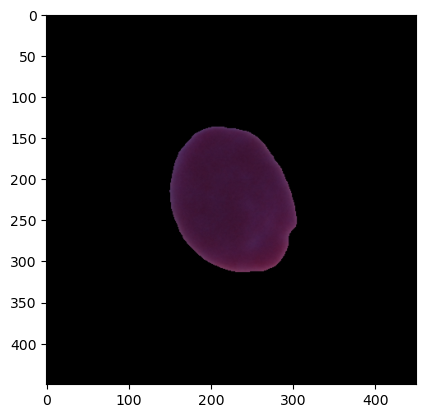

In [37]:
image = cv.imread(df["img_data"][100])
plt.imshow(image)

In [39]:
'''
Creat Model Structure
For high accuracy, it seems like we need to build on a pretrained CNN
The two top solutions on kaggle build on efficientnet and Resnet
We could build on VGG, which is another strong option
VGG19 extracts important features from the dataset
'''

model = VGG19(weights='imagenet',include_top=False, pooling="avg")


2024-04-18 15:48:51.524382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


80134624/80134624 [==============================] - 4s 0us/step
